# Prediction of AAPL stock using LR with ARMA errors (1995 - 2021)

<font color='red'>Include data in a longer term</font>

## Content
0. [Download Data from Yahoo Finance](#section0)
1. [Data preparation (LOWESS smoother)](#section1)
2. [Exploratory Data Analysis](#section2)
3. [Data Testing](#section3)
4. [Fitting an ARMA model](#section4)
5. [Residual Analysis](#section5)
6. [Prediction vs. Realized Values](#section6)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

### <a id='section0'></a> 0 $\bullet$ Import Apple Stock data from Yahoo Finance

In [2]:
start = '1995-01-01'
end = '2021-05-01'

In [3]:
aapl_df = yf.download(tickers='AAPL', start=start, end=end, interval='1wk')
print(aapl_df.head())
print(aapl_df.tail())
print(aapl_df.shape[0])

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close        Volume
Date                                                                       
1995-01-02  0.347098  0.385045  0.338170  0.375000   0.318824  1.412813e+09
1995-01-09  0.371652  0.429129  0.366071  0.400670   0.340649  2.665858e+09
1995-01-16  0.400670  0.419643  0.379464  0.380580   0.323568  1.961400e+09
1995-01-23  0.373884  0.380580  0.348214  0.356027   0.302693  1.678667e+09
1995-01-30  0.358259  0.376116  0.356027  0.361607   0.307437  1.124525e+09
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-03-29  121.650002  124.180000  118.860001  123.000000  122.791428   
2021-04-05  123.870003  133.039993  123.070000  133.000000  132.774475   
2021-04-12  132.520004  135.000000  130.630005  134.160004  133.932510   
2021-04-19  133.509995  135.5

### <a id='section1'></a> 1 $\bullet$ Data preparation

#### Check missing values

In [4]:
miss = aapl_df.isnull().sum()
print('no missing values' if miss.sum() == 0 else 'there are %d missing values' % miss.sum())
aapl_df[aapl_df.isna().any(axis=1)].head()

there are 258 missing values


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-02-13,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-26,NaN,NaN,NaN,NaN,NaN,NaN
1995-08-16,NaN,NaN,NaN,NaN,NaN,NaN
1995-11-21,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-21,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
aapl_df = aapl_df.dropna()  # remove the missing value rows

#### Date in the dataframe is set as index
Check the possible frequency of the index (date)

In [6]:
pd.infer_freq(aapl_df.index)

'W-MON'

#### LOWESS Smoothing

Use lowess smoother to have a better prediction of data.
https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

In [7]:
import statsmodels.nonparametric.smoothers_lowess as les

# to produce a smoother array using LOWESS
def lowess_smoother(x, y, frac=0.1):
    smo_res = les.lowess(endog=y, exog=x, frac=frac)
    smo_list = []
    for i in smo_res:
        smo_list.append(i[1])
    fig, ax = plt.subplots()
    ax.scatter(y=smo_list, x=x)
    return smo_list

Plot the original price and the price after LOWESS smoothing

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


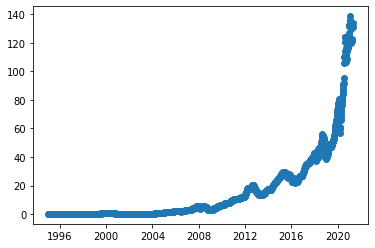

In [8]:
lowess_price = lowess_smoother(x=aapl_df.index, y=aapl_df['Adj Close'], frac=0.01)
aapl_df.rename(columns={'Adj Close': 'Original_Adj_Close'}, inplace=True)
aapl_df.insert(loc=3, column='Adj Close', value=lowess_price)

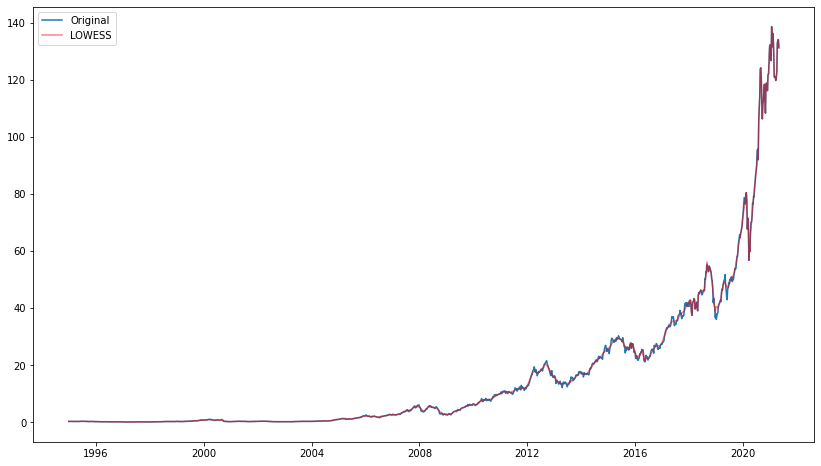

In [9]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(aapl_df.index, aapl_df['Original_Adj_Close'], label='Original')
ax.plot(aapl_df.index, aapl_df['Adj Close'], label='LOWESS', color='red', alpha=0.5)
ax.legend()

#### Maximum drawdown

<AxesSubplot:xlabel='date'>

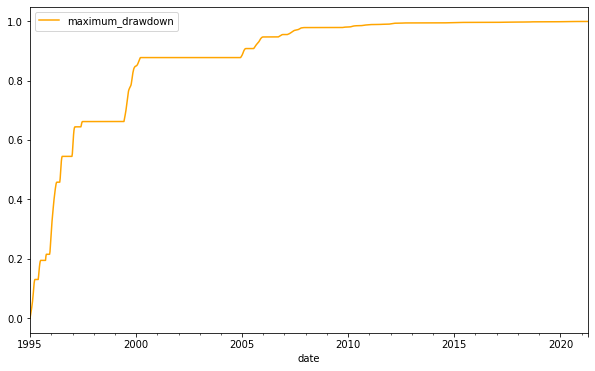

In [10]:
df0 = pd.DataFrame(index=['date'], columns=['maximum_drawdown'])
for i in aapl_df.index:
    maxdd_i = (aapl_df[:i]['Adj Close'].max() - aapl_df[:i]['Adj Close'].min()) / aapl_df[:i]['Adj Close'].max()
    df0 = pd.concat([df0, pd.DataFrame({'date': [i], 'maximum_drawdown': [maxdd_i]})], axis=0)
df0.set_index('date', inplace=True)
df0.dropna(inplace=True)

df0.plot(figsize=(10,6), c='orange')

#### Calculate arithmetic return

In [11]:
week_rt = (aapl_df['Adj Close']/aapl_df['Adj Close'].shift(1) - 1).rename('Weekly Return')
aapl_df = pd.concat([aapl_df, week_rt], axis=1)
year_rt = aapl_df['Adj Close']/aapl_df['Adj Close'].shift(52) - 1

#### Plot prices and return

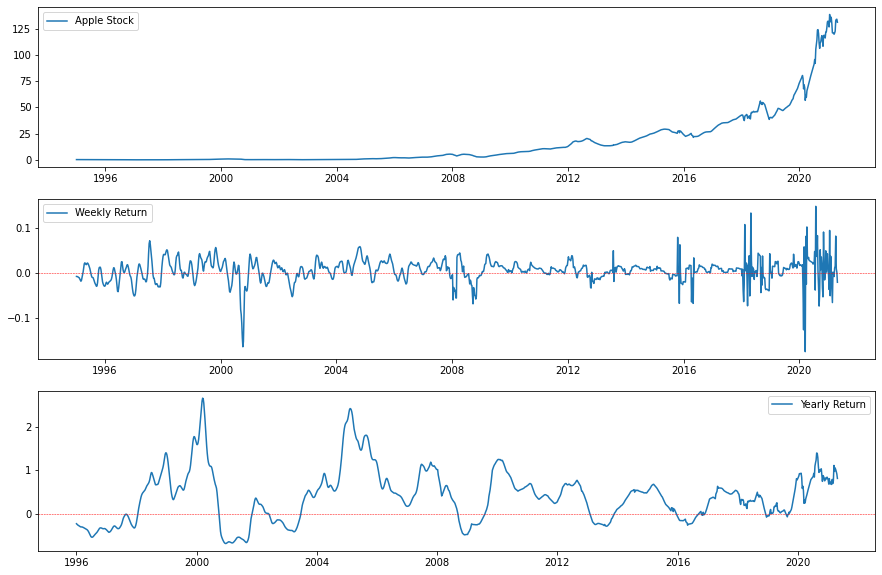

In [12]:
fig, ax = plt.subplots(3, figsize=(15, 10))
ax[0].plot(aapl_df['Adj Close'])
ax[1].plot(week_rt)
ax[2].plot(year_rt)
ax[1].axhline(y=0, c="r", linewidth=0.5, linestyle='--')
ax[2].axhline(y=0, c="r", linewidth=0.5, linestyle='--')
ax[0].legend(['Apple Stock'])
ax[1].legend(['Weekly Return'])
ax[2].legend(['Yearly Return'])

### <a id='section2'></a> 2 $\bullet$ Exploratory Data Analysis

#### Trend of other tech stocks (before smoothing)

In [13]:
tech_df = yf.download(tickers='AAPL IBM MSFT F', start=start, end=end, interval='1d')  # daily frequency

[*********************100%***********************]  4 of 4 completed


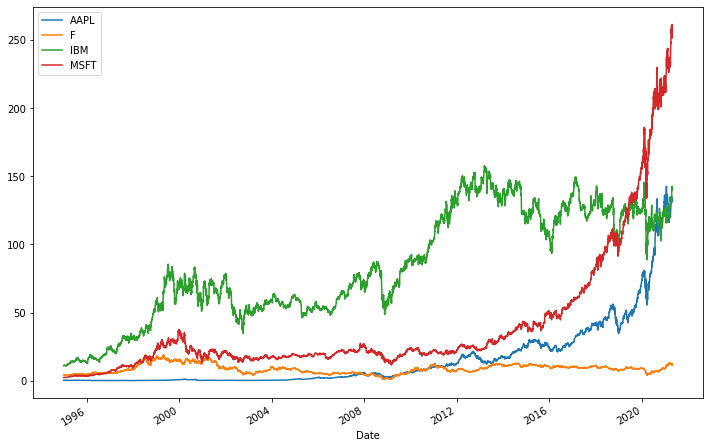

In [14]:
tech_df['Adj Close'].plot(figsize=(12,8))
del tech_df

#### Histograms

Text(0.5, 1.0, 'AAPL weekly return')

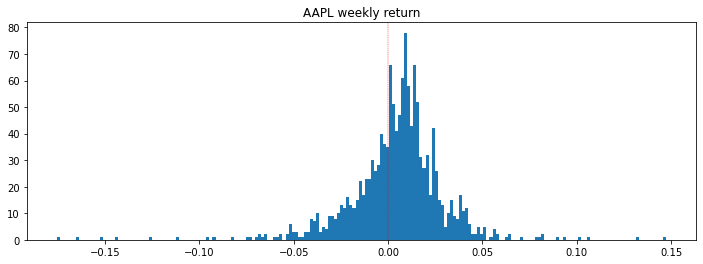

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(week_rt, bins=200)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')
plt.title('AAPL weekly return')

#### Histogram with Kernel Density Estimate (KDE)

Text(0.5, 1.0, 'AAPL weekly return')

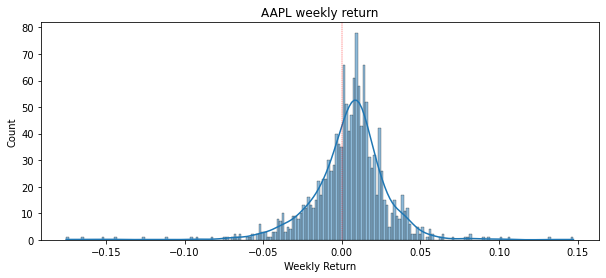

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(x=week_rt, kde=True, bins=200, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')
plt.title('AAPL weekly return')

#### Empirical cumulative density function

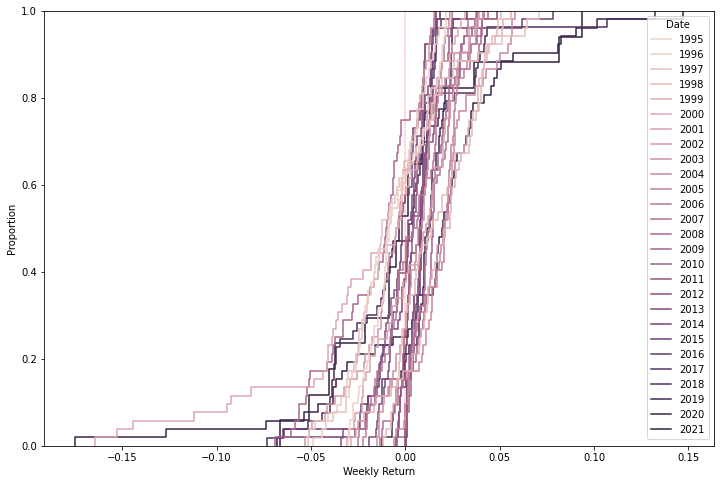

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
sns.ecdfplot(data=aapl_df, x=week_rt, hue=aapl_df.index.year, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Stacked histogram

Plot the histogram of the AAPL weekly returns, adding a hue for the different years and stacking the different years.

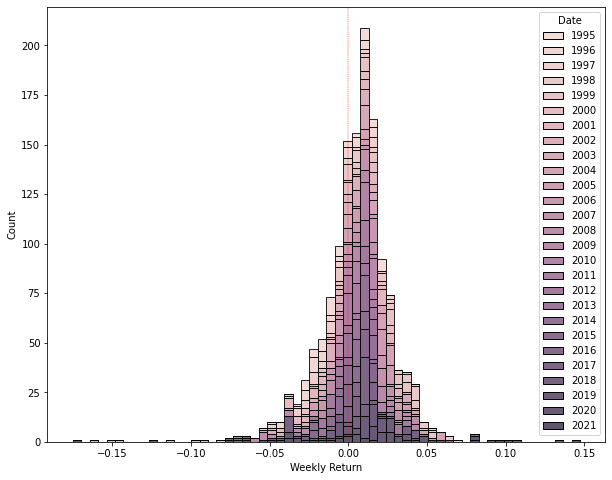

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=aapl_df, x=week_rt, hue=aapl_df.index.year, multiple='stack', bins=60, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Boxplot

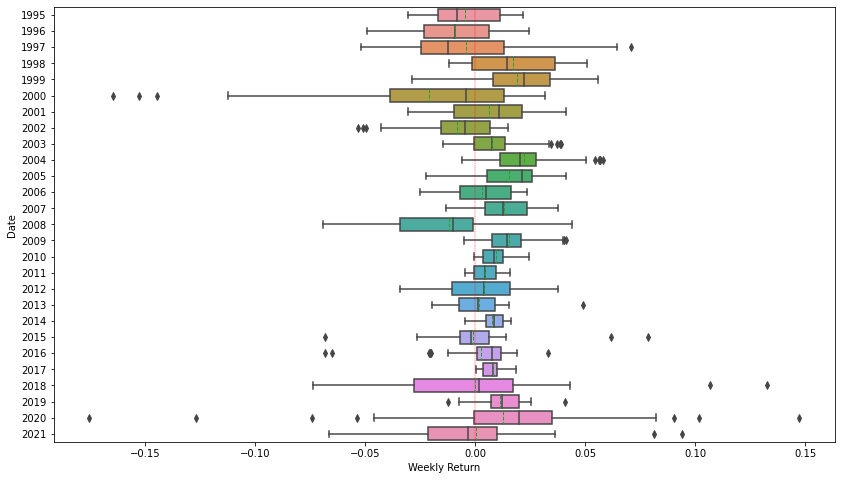

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(x=week_rt, y=aapl_df.index.year, orient='h',
            showmeans=True, meanline=True, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Scatterplot

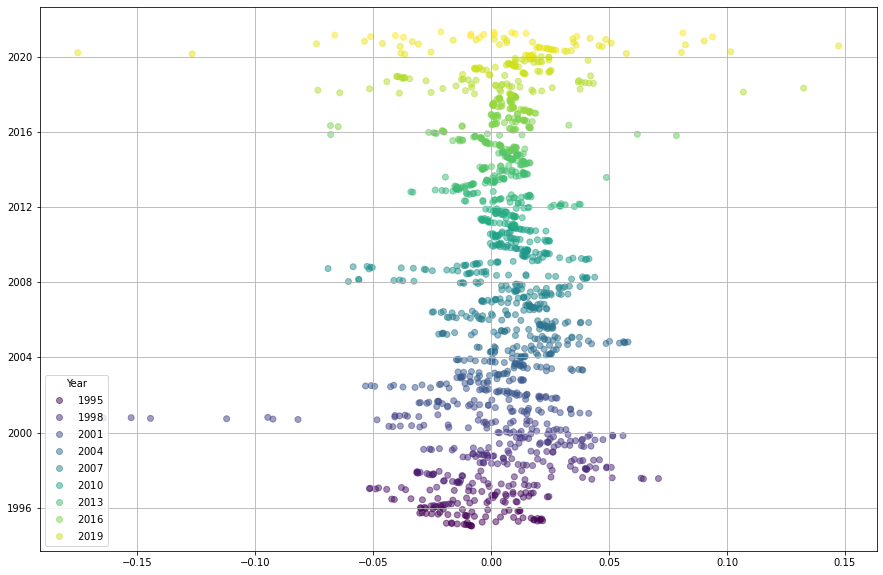

In [20]:
# plt.scatter(x=week_rt, y=aapl_df.index, c=aapl_df.index.year, alpha=0.5)
# plt.legend(aapl_df.index.year)
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(x=week_rt, y=aapl_df.index, c=aapl_df.index.year, alpha=0.5)
ax.legend(*scatter.legend_elements(),
                    loc='lower left', title='Year')
ax.grid()

### <a id='section3'></a> 3 $\bullet$ Data testing

#### Test for stationarity

In [21]:
from statsmodels.tsa.api import adfuller, kpss, acf

Augmented Dickey-Fuller stationarity test (null hypothesis: non-stationarity)

In [22]:
def print_adf_test(x):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct',
                   'constant, and linear and quadratic trend': 'ctt',
                   'no constant, no trend': 'nc'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [23]:
adf_test_price = print_adf_test(aapl_df['Adj Close'])  # ADF test for weekly price

,test statistic,p-value
constant only,4.4764,1.0
constant and trend,3.2295,1.0
"constant, and linear and quadratic trend",1.3641,1.0
"no constant, no trend",4.9078,1.0


p-value > 0.05, **we cannot reject the null hypothesis of non-stationarity**.

In [24]:
adf_test_rt = print_adf_test(week_rt.dropna())  # ADF test for weekly return

,test statistic,p-value
constant only,-6.0108,0.0
constant and trend,-6.0682,0.0
"constant, and linear and quadratic trend",-6.1591,0.0
"no constant, no trend",-5.6049,0.0


p-value < 0.05, reject the null hypothesis of non-stationarity. **The weekly return of AAPL is stationary.**

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test (Null hypothesis: stationarity)

In [25]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [26]:
print_kpss_test(aapl_df['Adj Close'])  # KPSS test for weekly price

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,test statistic,p-value
constant only,3.8865,0.01
constant and trend,0.9534,0.01


,test statistic,p-value
constant only,3.886512,0.01
constant and trend,0.953443,0.01


p-value < 0.01, **we have 99% confidence to reject the null hypothesis of stationarity**.

In [27]:
print_kpss_test(week_rt.dropna())  # KPSS test for weekly return

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,test statistic,p-value
constant only,0.1781,0.1
constant and trend,0.0797,0.1


,test statistic,p-value
constant only,0.178054,0.1
constant and trend,0.079745,0.1


p-value > 0.1, we cannot reject the null hypothesis of stationarity. **The weekly return is stationary.**

#### Test for autocorrelation

Autocorrelation function ACF:
    $$\rho(h) = \frac{\gamma(h)}{\gamma(0)}$$
    where $$\gamma(h) = Cov(X_t, X_{t-h})$$

$\bullet$ Individual test for some h > 0, 
$$H_0: \rho(h) = 0$$
$$H_1: \rho(h) ≠ 0$$

In practice, one need at least T ⩾ 50 (T is the number of observations) and h ⩽ T/4. In this case T = 1153, so h ⩽ 288.

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [29]:
def acf_pacf(x, lags=50):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(x, lags=lags, ax=ax[0])
    plot_pacf(x, lags=lags, ax=ax[1])
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    ax[0].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    ax[1].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    
    ax[0].legend()
    ax[1].legend()
    
    return fig

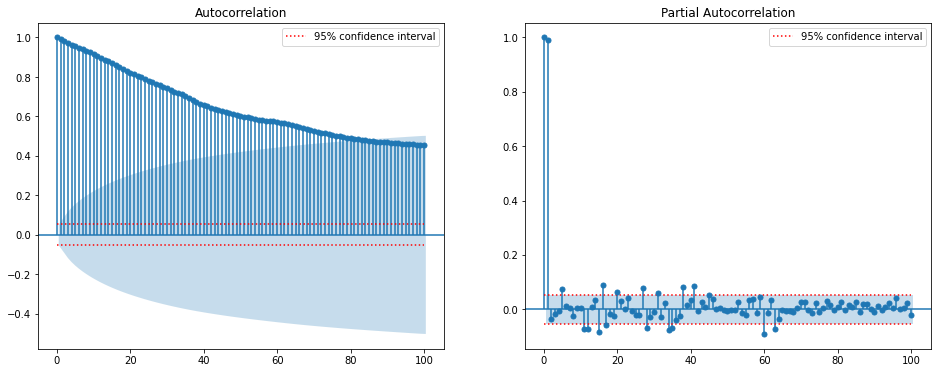

In [30]:
acf_plot_price = acf_pacf(aapl_df['Adj Close'], lags=100)

The autocorrelation effect decreases when lag increases. The autocorrelation at lag=1 indicates that **we can conclude that the stock price of AAPL is not white noise.**

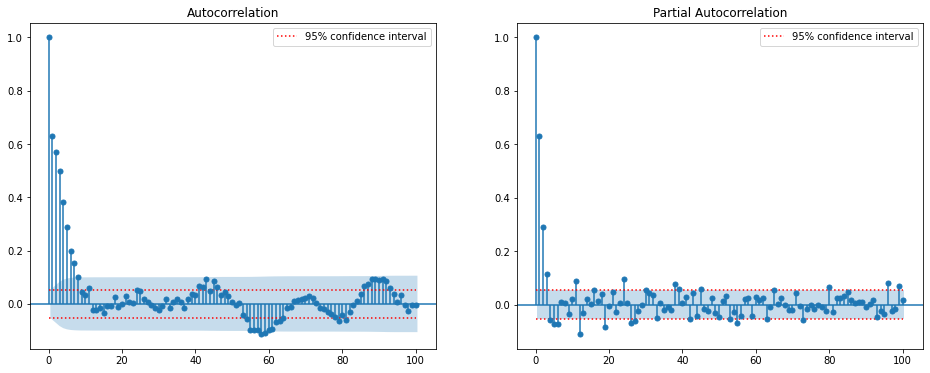

In [31]:
acf_plot_rt = acf_pacf(week_rt.dropna(), lags=100)

We can conclude that **weekly return is not white noise.**

$\bullet$ Joint test: the Ljung–Box Q test
For some m << T,
$$\begin{align}
H_0: \rho(1) = ... = \rho(m) = 0\\
H_1: \exists 1 ≤ h ≤ m,\rho(h) ≠ 0 \\
\end{align}$$

In [32]:
def print_acf(x, lags):
    val, qstat, pval = acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)
    return df

In [33]:
lags = np.array([1, 2, 3, 5, 7, 10, 20])
res1 = print_acf(aapl_df['Adj Close'], lags)

,Q Statistic,p-value (%)
up to lag 1,1353.37,0.0
up to lag 2,2682.96,0.0
up to lag 3,3988.40,0.0
up to lag 5,6530.84,0.0
up to lag 7,8995.19,0.0
up to lag 10,12547.50,0.0
up to lag 20,22960.64,0.0


We can reject the null hypothesis that autocorrelation does not exist. So **weekly price is not a white noise.**

In [34]:
res2 = print_acf(week_rt.dropna(), lags)

,Q Statistic,p-value (%)
up to lag 1,547.51,0.0
up to lag 2,996.85,0.0
up to lag 3,1341.75,0.0
up to lag 5,1660.34,0.0
up to lag 7,1747.03,0.0
up to lag 10,1765.80,0.0
up to lag 20,1775.09,0.0


We can reject the null hypothesis that autocorrelation does not exist. So **weekly return is not white noise.**

### <a id='section4'></a> 4 $\bullet$ Fitting an ARMA model

$\bullet$ Selecting a model with information criteria 
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html  
`trend='c'` includes constant  
`trend='nc'` no constant: long run mean is zero

In [35]:
from statsmodels.tsa import stattools

# Silence the warning
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [36]:
def select_arma(x, max_ar=2, max_ma=2, trend='c'):
    res = stattools.arma_order_select_ic(x, max_ar=max_ar, max_ma=max_ma, ic=['aic', 'bic'], trend=trend)
    res['aic'].index.names = ['AR Lags']
    res['aic'].columns.names = ['MA Lags']
    res['bic'].index.names = ['AR Lags']
    res['bic'].columns.names = ['MA Lags']
    res['aic'].columns = pd.MultiIndex.from_product([['AIC'],res['aic'].columns])
    res['bic'].columns = pd.MultiIndex.from_product([['BIC'],res['bic'].columns])

    display(res['aic'].round(1))
    print('AIC selected order: ', res['aic_min_order'])
    display(res['bic'].round(1))
    print('BIC selected order: ', res['bic_min_order'])
    
    return res

In [37]:
res = select_arma(aapl_df['Adj Close'], max_ar=5, max_ma=5, trend='c')

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_pa

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fa

AIC                                         
MA Lags        0        1       2       3       4       5
AR Lags                                                  
0        12802.7  10977.5  9495.0  8394.0  7604.8  7015.5
1         4309.9   4295.0  4282.6  4270.5  4272.5  4266.3
2         4303.0   4295.9  4295.2  4275.6  4269.5  4270.3
3         4289.8   4295.3  4283.5  4273.0  4238.5  4231.6
4         4285.0   4273.7  4282.3  4279.3  4230.4  4182.4
5         4285.9   4273.1  4238.1  4292.2  4229.0  4189.6

AIC selected order:  (4, 5)


BIC                                         
MA Lags        0        1       2       3       4       5
AR Lags                                                  
0        12813.2  10993.2  9515.9  8420.1  7636.2  7052.1
1         4325.6   4315.9  4308.7  4301.9  4309.1  4308.1
2         4323.9   4322.1  4326.5  4312.2  4311.3  4317.3
3         4315.9   4326.7  4320.1  4314.8  4285.5  4283.8
4         4316.3   4310.3  4324.1  4326.3  4282.6  4239.9
5         4322.5   4314.9  4285.1  4344.4  4286.4  4252.3

BIC selected order:  (4, 5)


Based on the result of both information criteria, we fit ARMA(5, 5) model to the dataset.
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html

In [38]:
import statsmodels.tsa.arima.model as smt_arima
model = smt_arima.ARIMA(aapl_df['Adj Close'], order=(5, 0, 5))  # ARMA function is deprecated

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [39]:
fitted_model = model.fit()
fitted_model.summary()

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1374
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -2081.072
Date:                Sun, 06 Jun 2021   AIC                           4186.145
Time:                        15:11:41   BIC                           4248.851
Sample:                    01-02-1995   HQIC                          4209.608
                         - 04-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7646   2039.304      0.008      0.994   -3981.199    4012.728
ar.L1         -1.0601      0.030    -35.870      0.000      -1.118      -1.002
ar.L2         -0.3153      0.011    -28.884      0.000      -0.337      -0.294
ar.L3          0.4368      0.005     87.912      0.000       0.427       0.447
ar.L4          1.2219      0.012     98.522      0.000       1.198       1.246
ar.L5          0.7166      0.028     25.231      0.000       0.661       0.772
ma.L1          2.1126      0.030     71.192      0.000       2.054       2.171
ma.L2          2.5869      0.040     64.104      0.000       2.508       2.666
ma.L3          2.2761      0.042     54.311      0.000       2.194       2.358
ma.L4          1.0513      0.032     33.027      0.000       0.989       1.114
ma.L5          0.1859      0.008     23.287      0.000       0.170       0.202
sigma2         1.1832      0.013     94.077      0.000       1.159       1.208
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):            139086.53
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):           27941.12   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='section5'></a> 5 $\bullet$ Residual Analysis

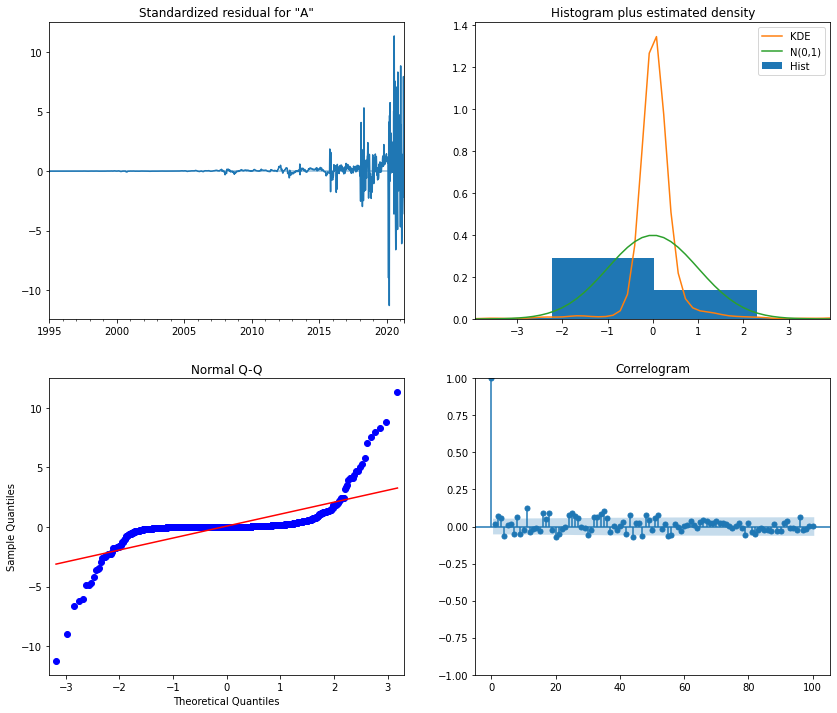

In [40]:
fig = fitted_model.plot_diagnostics(figsize=(14,12), lags=100)

We confirm the absence of autocorrelation seen in the Correlogram with the Ljung-Box Q Test.  
This proves that the ARMA model has captured most of the autocorrelation structure that is in the weekly price dataset.

In [41]:
res = print_acf(fitted_model.resid, lags)

,Q Statistic,p-value (%)
up to lag 1,0.26,61.25
up to lag 2,5.39,6.75
up to lag 3,9.38,2.46
up to lag 5,14.10,1.50
up to lag 7,17.11,1.67
up to lag 10,24.83,0.57
up to lag 20,72.45,0.00


p-value > 0.05, we cannot reject the null hypothesis of no autocorrelation.

### <a id='section6'></a> 6 $\bullet$ Prediction vs. Realized Values

In [42]:
forecast = fitted_model.get_forecast(steps=25)  # Predict values for next 25 weeks
f = forecast.summary_frame()
f.tail()

Adj Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-09-20,130.320602,5.628468,119.289007,141.352196
2021-09-27,130.320224,5.770269,119.010704,141.629745
2021-10-04,128.212981,5.899835,116.649517,139.776446
2021-10-11,129.020343,6.021703,117.218021,140.822664
2021-10-18,130.818131,6.152707,118.759048,142.877214


Plot the predicted values

In [43]:
aapl = yf.Ticker('AAPL')
realized_value = aapl.history(start=min(f.index), end=datetime.date.today())

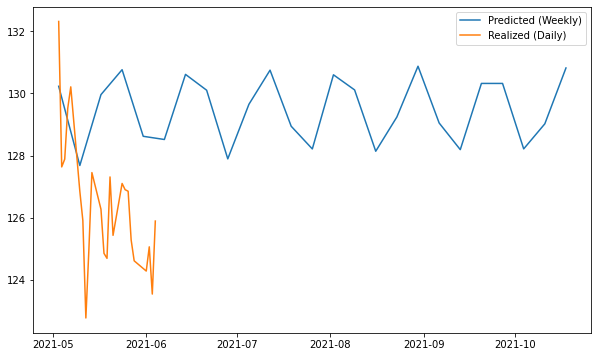

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(f['mean'], label='Predicted (Weekly)')
ax.plot(realized_value['Close'], label='Realized (Daily)')
ax.legend()